This notebook have example of usage classification pipeline for Alrosa gems color classification with attention layer for multi-image classification

In [1]:
# Imports
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
import numpy as np
from PIL import Image

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

sys.path.append('../..') #add root directory of project to import needed modules
from preprocess import preprocess
from train_model import train_model
from evaluate_model import evaluate, evaluate_model, compute_metrics

from configuration import Configuration
from utils import load_json, load_dataset, aggregate_detailed_classes
import cv2
from utils import build_data_loader, load_model, plot_probabilities_distribution
from utils import show_mistakes_by_target, show_mistakes_by_pred, save_json

from pprint import pprint as pp

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

# load data

Dataset was already collected, one should collect dataset that meet conditions described above

In [3]:
# choose path to your dataset
path_to_dataset = '/storage/bigdata/alrosa_project/raw_from_ftp/nurba/classification_pipeline_example/images.csv'

In [4]:
images = pd.read_csv(path_to_dataset)

Dataset is supposed to have the following columns:
- *class_name*: str
- *obj_id* - id of one item. Unique for single image classification. Images of the same object must have the same *obj_id* (for multi image classification)
- *img_path*: str - path to image
- *target*: int - encoding of classes



In [5]:
images.head()

,class_name,obj_id,img_path,target
0,4Col,2021-06-07_10-50-22-147/141,/storage/bigdata/alrosa_project/raw_from_ftp/n...,6
1,4Col,2021-06-07_10-50-22-147/141,/storage/bigdata/alrosa_project/raw_from_ftp/n...,6
2,4Col,2021-06-07_10-50-22-147/166,/storage/bigdata/alrosa_project/raw_from_ftp/n...,6
3,4Col,2021-06-07_10-50-22-147/166,/storage/bigdata/alrosa_project/raw_from_ftp/n...,6
4,4Col,2021-06-07_10-50-22-147/215,/storage/bigdata/alrosa_project/raw_from_ftp/n...,6


In out case there are 2 images per one gem (from 2 cameras)  
We are going to train attention model simulteniously using images with the same **obj_ids**

In [6]:
images['obj_id'].value_counts()

2021-06-07_10-50-22-147/141    2
2021-06-07_11-36-05-944/152    2
2021-06-07_11-36-05-944/179    2
2021-06-07_11-36-05-944/132    2
2021-06-07_11-36-05-944/274    2
                              ..
2021-06-07_10-05-54-146/5      2
2021-06-07_10-05-54-146/57     2
2021-06-07_10-05-54-146/177    2
2021-06-07_10-05-54-146/255    2
2021-06-07_12-17-42-560/55     2
Name: obj_id, Length: 2645, dtype: int64

In [7]:
images.class_name.value_counts()

3-4Brn    668
1Col      664
2Col      626
3Col      620
Cape      618
4Col      614
2Brn      488
1Brn      428
5-6Brn    336
Grey      228
Name: class_name, dtype: int64

In [8]:
# Define class_names with names of classes in dataset to print confusion matrix correctly 
# order of classes is important

class_names = [
    '1Brn', '1Col', '2Brn', '2Col', '3-4Brn', '3Col', '4Col', '5-6Brn', 
    'Cape', 'Grey'
]

In [9]:
# target mapping
# encode classes names to target

target_mapper = {
    '1Brn':0,
    '1Col':1,
    '2Brn':2,
    '2Col':3,
    '3-4Brn':4,
    '3Col':5,
    '4Col':6,
    '5-6Brn':7,
    'Cape':8,
    'Grey':9
}

images['target'] = images['class_name'].map(target_mapper)

# set experiment params

One could use configuration file from  './configs/classification.json' or add your own config.  
One could as well change config parameters from notebook as presented in the following cell

In [10]:
config_path = './configs/classification.json'
config_json = load_json(config_path)
pp(config_json)

config_json['MODEL_PARAMS']['num_classes'] = images.target.nunique()
config_json['CUDA_NUMBER'] = 0 # put None to use cpu
config_json['EXP_NAME'] = 'classification_atttention'


config_json['CONFIG_PARAMS']['MODEL'] = 'efficientnet_attn_pretrained' # names are taken from configuration.py script
config_json['CONFIG_PARAMS']['TRAINER'] = 'trainer_attention'
config_json['CONFIG_PARAMS']['COLLECTION'] = 'collection_attention'


config_json["EXP_PARAMS"]['num_epochs'] = 10
config_json["EXP_PARAMS"]['batch_size'] = 15

{'CONFIG_PARAMS': {'COLLECTION': 'collection_separate',
                   'MODEL': 'resnet50_imagenet',
                   'TRAINER': 'trainer_separate'},
 'CUDA_NUMBER': 0,
 'DATA_PATH': '/storage2/open',
 'EPOCH': None,
 'EXP_NAME': 'detailes_classification/',
 'EXP_PARAMS': {'batch_size': 40,
                'filter_df': True,
                'lr': 1e-05,
                'model_name': 'imagenet_pretrained_baseline_v1',
                'num_epochs': 100,
                'use_balanced_weights': True,
                'use_norm': True},
 'MODEL_PARAMS': {'num_classes': 6},
 'PRETRAINED': 1,
 'SEED': 55}


In [11]:
config = Configuration(config_json)

In [12]:
SEED = 55

data_path = config.DATA_PATH
print(data_path)
experiment_name = config_json['EXP_NAME']
print(experiment_name)
try:
    seed = config.SEED
except KeyError:
    seed = SEED

path_to_save = f'./experiments/{experiment_name}'

/storage2/open
classification_atttention


# split data

Split data to train/val/test with obj_id stratification

In [14]:
from sklearn.model_selection import train_test_split

# split by obj_id STRATIFY
gems = images.groupby(['obj_id'])['target'].first().reset_index()

train_gems, test_gems = train_test_split(gems, stratify=gems['target'], test_size=0.1, random_state=seed)
train_gems, val_gems = train_test_split(train_gems, stratify=train_gems['target'], test_size=0.2, random_state=seed)

train_gems = train_gems['obj_id'].values
val_gems = val_gems['obj_id'].values
test_gems = test_gems['obj_id'].values

train = images[images['obj_id'].isin(train_gems)].sample(frac=1, random_state=seed).reset_index(drop=True)
val = images[images['obj_id'].isin(val_gems)].reset_index(drop=True)
test = images[images['obj_id'].isin(test_gems)].reset_index(drop=True)

print(f'Split shapes for train / val / test: {train.shape[0]} / {val.shape[0]} / {test.shape[0]} \n')
print('Train class share: \n', train['target'].value_counts().sort_index() / len(train))
print('Val class share: \n', val['target'].value_counts().sort_index() / len(val))
print('Test class share: \n', test['target'].value_counts().sort_index() / len(test))

if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

# save data sets
train.to_csv(os.path.join(path_to_save, 'train.csv'), index=False)
val.to_csv(os.path.join(path_to_save, 'val.csv'), index=False)
test.to_csv(os.path.join(path_to_save, 'test.csv'), index=False)

save_json({'class_names': class_names}, os.path.join(path_to_save, 'metadata.json'))
print('Preprocessing stage is finished.')

Split shapes for train / val / test: 3808 / 952 / 530 

Train class share: 
 0    0.081408
1    0.125525
2    0.091912
3    0.118697
4    0.126050
5    0.117122
6    0.116071
7    0.063550
8    0.116597
9    0.043067
Name: target, dtype: float64
Val class share: 
 0    0.079832
1    0.126050
2    0.092437
3    0.117647
4    0.126050
5    0.117647
6    0.115546
7    0.063025
8    0.117647
9    0.044118
Name: target, dtype: float64
Test class share: 
 0    0.079245
1    0.124528
2    0.094340
3    0.116981
4    0.128302
5    0.116981
6    0.116981
7    0.064151
8    0.116981
9    0.041509
Name: target, dtype: float64
Preprocessing stage is finished.


# train model

In [15]:
pp(config_json)

{'CONFIG_PARAMS': {'COLLECTION': 'collection_attention',
                   'MODEL': 'efficientnet_attn_pretrained',
                   'TRAINER': 'trainer_attention'},
 'CUDA_NUMBER': 0,
 'DATA_PATH': '/storage2/open',
 'EPOCH': None,
 'EXP_NAME': 'classification_atttention',
 'EXP_PARAMS': {'batch_size': 15,
                'filter_df': True,
                'lr': 1e-05,
                'model_name': 'imagenet_pretrained_baseline_v1',
                'num_epochs': 10,
                'use_balanced_weights': True,
                'use_norm': True},
 'MODEL_PARAMS': {'num_classes': 10},
 'PRETRAINED': 1,
 'SEED': 55}


In [16]:
experiment_folder_path = os.path.join('./experiments/', experiment_name)
print('Experiment path: \t', experiment_folder_path)

# delete folder if needed
model_path = os.path.join(experiment_folder_path, config.EXP_PARAMS['model_name'])
print('Model path: \t\t', model_path)
#!rm {model_path} -r

Experiment path: 	 ./experiments/classification_atttention
Model path: 		 ./experiments/classification_atttention/imagenet_pretrained_baseline_v1


In [17]:
best_epoch = train_model(experiment_folder_path, config)

Starting model training stage...
Train set size:  (3808, 4)
Val set size:  (952, 4)
Class weights: 
 [1.2283871  0.79665272 1.088      0.84247788 0.79333333 0.85381166
 0.86153846 1.57355372 0.85765766 2.32195122]
Loaded pretrained weights for efficientnet-b3
Epoch: 0 | phase: train |: 19:12:30
Loss: 2.198762, Score: 0.281513
Epoch: 0 | phase: val |: 19:13:29
Loss: 3.439836, Score: 0.079832
******** New optimal found, saving state ********

Epoch: 1 | phase: train |: 19:13:34
Loss: 1.857649, Score: 0.45063
Epoch: 1 | phase: val |: 19:14:32
Loss: 2.036823, Score: 0.292017
******** New optimal found, saving state ********

Epoch: 2 | phase: train |: 19:14:36
Loss: 1.503852, Score: 0.508403
Epoch: 2 | phase: val |: 19:15:35
Loss: 1.294601, Score: 0.607143
******** New optimal found, saving state ********

Epoch: 3 | phase: train |: 19:15:40
Loss: 1.261664, Score: 0.56355
Epoch: 3 | phase: val |: 19:16:37
Loss: 1.026482, Score: 0.670168
******** New optimal found, saving state ********

Ep

# evaluate model

Starting model validation stage on test.csv set...
Loaded pretrained weights for efficientnet-b3


100%|████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  5.57it/s]


Accuracy:  0.7660377358490567
Precision:  0.7702338323712519
Recall:  0.7660377358490567
Class. report:
               precision    recall  f1-score   support

        1Brn       0.89      0.81      0.85        21
        1Col       0.78      0.88      0.83        33
        2Brn       0.75      0.72      0.73        25
        2Col       0.71      0.55      0.62        31
      3-4Brn       0.71      0.65      0.68        34
        3Col       0.78      0.68      0.72        31
        4Col       0.80      0.77      0.79        31
      5-6Brn       0.67      0.82      0.74        17
        Cape       0.91      1.00      0.95        31
        Grey       0.56      0.91      0.69        11

    accuracy                           0.77       265
   macro avg       0.76      0.78      0.76       265
weighted avg       0.77      0.77      0.76       265



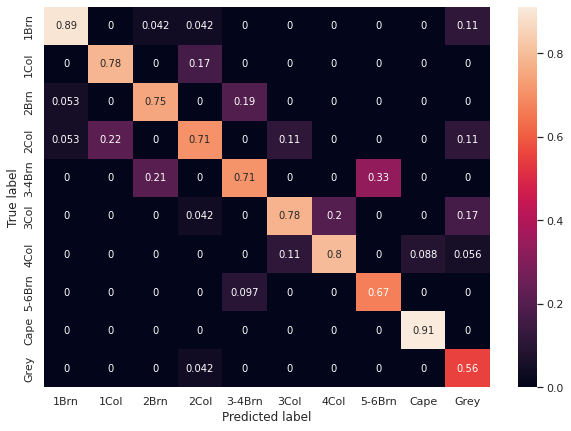

Conf. matrix:
 [[17  0  1  1  0  0  0  0  0  2]
 [ 0 29  0  4  0  0  0  0  0  0]
 [ 1  0 18  0  6  0  0  0  0  0]
 [ 1  8  0 17  0  3  0  0  0  2]
 [ 0  0  5  0 22  0  0  7  0  0]
 [ 0  0  0  1  0 21  6  0  0  3]
 [ 0  0  0  0  0  3 24  0  3  1]
 [ 0  0  0  0  3  0  0 14  0  0]
 [ 0  0  0  0  0  0  0  0 31  0]
 [ 0  0  0  1  0  0  0  0  0 10]]
Model evaluation is finished.


In [18]:
pred, results = evaluate_model(best_epoch, experiment_folder_path, 'test', config)

# Aggregate results

And aggregate detailed classes.  
For example aggregate "1Col", "2Col", "3Col" to "White"

In [19]:
mapper_aggregated = {
    0: 'White',
    1: 'Light Brown',
    2: 'Dark Brown',
    3: 'Grey',
    4: 'Yellow',
}

Write dict for classes to aggregate

In [20]:
aggregated_class_map = {
    0:1,
    1:0,
    2:2,
    3:0,
    4:2,
    5:0,
    6:4,
    7:2,
    8:4,
    9:3,
}

In [21]:
pred_gem_aggregated = aggregate_detailed_classes(pred, aggregated_class_map)

In [22]:
aggregated_classes = ['White', 'Light Brown', 'Dark Brown', 'Grey', 'Yellow']

Accuracy:  0.9207547169811321
Precision:  0.9218120271658454
Recall:  0.9207547169811321
Class. report:
               precision    recall  f1-score   support

       White       0.94      0.92      0.93        95
 Light Brown       0.88      0.71      0.79        21
  Dark Brown       0.96      0.99      0.97        76
        Grey       0.69      0.82      0.75        11
      Yellow       0.91      0.94      0.92        62

    accuracy                           0.92       265
   macro avg       0.88      0.87      0.87       265
weighted avg       0.92      0.92      0.92       265



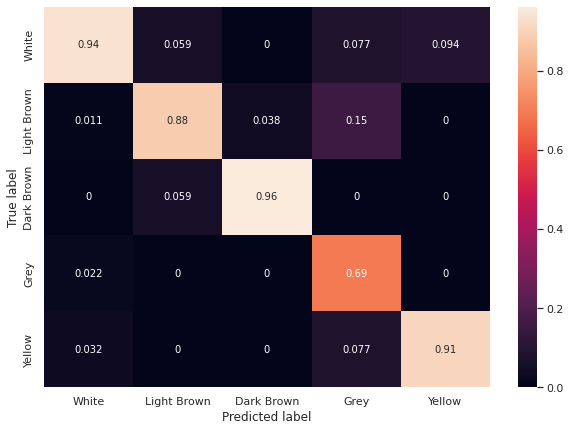

Conf. matrix:
 [[87  1  0  1  6]
 [ 1 15  3  2  0]
 [ 0  1 75  0  0]
 [ 2  0  0  9  0]
 [ 3  0  0  1 58]]


In [23]:
r = compute_metrics(pred_gem_aggregated, aggregated_classes)